In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pickle
import lzma
import matplotlib.pyplot as plt
import csv
import h5py
from tqdm import tqdm
import multiprocessing
from scipy.ndimage import label, generate_binary_structure
sys.path.insert(0, os.path.abspath('/home/suryakalia/documents/summer/exploration/kasthurilab_connectomics/'))
# Need to add above path since VSCode Jupyter Notebook doesn't respect system's $PYTHONPATH variable
# This will be eliminated once my module is converted to a conda package and installed to the conda env

from sk_connectomics.util.visualize import *

In [2]:
f = h5py.File("/home/suryakalia/documents/summer/datasets/cremi/sample_A_20160501.hdf", 'r')
neuron_ids = np.array(f["volumes/labels/neuron_ids"])
clefts = np.array(f["volumes/labels/clefts"])


In [18]:
def process_segment(img, segment_id, segment_volume, min_fraction_to_split, max_label):
  binary_mask = np.where(img == segment_id , 1, 0).astype(np.uint8)
  # 26-neighbor connectivity in 3D
  labeled_mask, num_features = label(binary_mask, structure=np.ones((3,3,3)))
  if (not num_features == 1):
    # Multiple components found. Check for splits/patches
    print("Incorrect segmentation detected for segment id =", segment_id, "volume = ", segment_volume, "num_features =", num_features)
    (unique, counts) = np.unique(labeled_mask, return_counts=True)
    segment_volume_map = dict(zip(unique, counts))
    sorted_segment_volume_map = dict(sorted(segment_volume_map.items(), key=lambda item: item[1], reverse = True))
    largest = True
    for id, vol in sorted_segment_volume_map.items():
      if id == 0:
        continue
      if largest:
        # Set original segment_id to the largest component
        labeled_mask = np.where(labeled_mask == id, segment_id, labeled_mask)
        largest = False
      else:
        # Check if segment constitutes a significant fraction of the parent segment
        if vol/segment_volume >= min_fraction_to_split :
          # Got a valid segment. Provide a new label
          max_label += 1
          print("Found a split in segmentation. New split segment_id, vol = ", max_label, ",", vol, "volume ratio = ", vol/segment_volume)
          labeled_mask = np.where(labeled_mask == id, max_label, labeled_mask)
        else:
          # Got a small splinter. Eliminate segment
          print("Eliminated splinter of size ratio: ", vol/segment_volume)
          labeled_mask = np.where(labeled_mask == id, 0, labeled_mask)
    
    return labeled_mask, max_label

  else:
    # Correct segmentation. All part of one connected component
    mask = segment_id * binary_mask
    return mask, max_label

def cleanup_segmentation_image(img, vol_threshold, min_fraction_to_split):
  clean_img = np.zeros(img.shape)
  # Eliminate any background pixels
  img = np.where(img==(2**64 - 1), 0, img)
  # Track current max label for creating new labels if needed
  max_label = np.max(img)
  (unique, counts) = np.unique(img, return_counts=True)
  for i in tqdm(range(len(unique))):
    # Ignore background segments. Can be splintered
    if (unique[i] == 0):
      continue
    # Process segment only if above threshold
    if (counts[i] >= vol_threshold):
      mask, max_label = process_segment(img, unique[i], counts[i], min_fraction_to_split, max_label)
      clean_img += mask
      
      
  
  return clean_img

In [15]:
clean_clefts = cleanup_segmentation_image(clefts, 100, 0.1)

  0%|          | 0/124 [00:00<?, ?it/s]

Incorrect segmentation detected for segment id =  604  volume =  4046  num_features =  2
Found a split in segmentation. New split segment_id, vol =  885.0  ,  2619  volume ratio =  0.6473059812160158
Found a split in segmentation. New split segment_id, vol =  886.0  ,  1427  volume ratio =  0.3526940187839842


 10%|█         | 13/124 [00:39<04:31,  2.44s/it]

Incorrect segmentation detected for segment id =  754  volume =  3133  num_features =  2
Found a split in segmentation. New split segment_id, vol =  887.0  ,  3132  volume ratio =  0.999680817108203
Eliminated splinter of size ratio:  0.0003191828917969997


 22%|██▏       | 27/124 [01:22<04:01,  2.49s/it]

Incorrect segmentation detected for segment id =  769  volume =  5576  num_features =  3
Found a split in segmentation. New split segment_id, vol =  888.0  ,  5572  volume ratio =  0.9992826398852224
Eliminated splinter of size ratio:  0.0003586800573888092
Eliminated splinter of size ratio:  0.0003586800573888092


 27%|██▋       | 33/124 [01:46<04:23,  2.89s/it]

Incorrect segmentation detected for segment id =  775  volume =  5686  num_features =  2
Found a split in segmentation. New split segment_id, vol =  889.0  ,  5685  volume ratio =  0.9998241294407316
Eliminated splinter of size ratio:  0.00017587055926837847


 34%|███▍      | 42/124 [02:15<03:30,  2.56s/it]

Incorrect segmentation detected for segment id =  786  volume =  6405  num_features =  3
Found a split in segmentation. New split segment_id, vol =  890.0  ,  2940  volume ratio =  0.45901639344262296
Found a split in segmentation. New split segment_id, vol =  891.0  ,  2431  volume ratio =  0.3795472287275566
Found a split in segmentation. New split segment_id, vol =  892.0  ,  1034  volume ratio =  0.16143637782982045


 56%|█████▋    | 70/124 [03:34<02:14,  2.49s/it]

Incorrect segmentation detected for segment id =  818  volume =  1529  num_features =  2
Found a split in segmentation. New split segment_id, vol =  893.0  ,  1528  volume ratio =  0.999345977763244
Eliminated splinter of size ratio:  0.0006540222367560497


 62%|██████▏   | 77/124 [04:00<02:12,  2.81s/it]

Incorrect segmentation detected for segment id =  825  volume =  5322  num_features =  2
Found a split in segmentation. New split segment_id, vol =  894.0  ,  5317  volume ratio =  0.9990605035700865
Eliminated splinter of size ratio:  0.0009394964299135663


 86%|████████▋ | 107/124 [05:23<00:40,  2.37s/it]

Incorrect segmentation detected for segment id =  857  volume =  1858  num_features =  2
Found a split in segmentation. New split segment_id, vol =  895.0  ,  1179  volume ratio =  0.6345532831001076
Found a split in segmentation. New split segment_id, vol =  896.0  ,  679  volume ratio =  0.36544671689989233


 87%|████████▋ | 108/124 [05:34<01:17,  4.85s/it]

Incorrect segmentation detected for segment id =  858  volume =  4785  num_features =  7
Found a split in segmentation. New split segment_id, vol =  897.0  ,  4760  volume ratio =  0.9947753396029259
Eliminated splinter of size ratio:  0.0014629049111807733
Eliminated splinter of size ratio:  0.0012539184952978057
Eliminated splinter of size ratio:  0.0010449320794148381
Eliminated splinter of size ratio:  0.0008359456635318704
Eliminated splinter of size ratio:  0.0004179728317659352
Eliminated splinter of size ratio:  0.0002089864158829676


 98%|█████████▊| 122/124 [06:19<00:04,  2.39s/it]

Incorrect segmentation detected for segment id =  881  volume =  5903  num_features =  2
Found a split in segmentation. New split segment_id, vol =  898.0  ,  5902  volume ratio =  0.9998305946129087
Eliminated splinter of size ratio:  0.0001694053870913095


100%|██████████| 124/124 [06:32<00:00,  3.16s/it]


In [22]:
(unique, counts) = np.unique(clefts, return_counts=True)
np.partition(unique, -2)[-2]

884

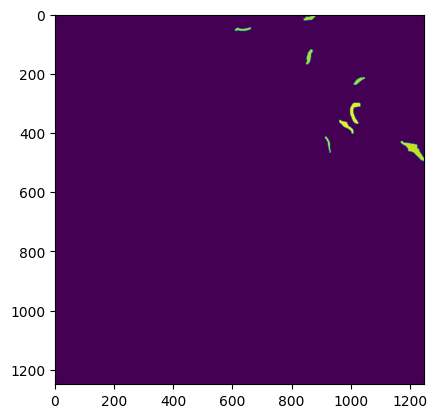

In [24]:
plt.imshow(clean_clefts[0])

In [25]:
with lzma.open("/home/suryakalia/documents/summer/datasets/cremi_clean/" + "clean_clefts.xz", "wb") as f:
  pickle.dump(clean_clefts, f)
          

In [26]:
clean_neuron_ids = cleanup_segmentation_image(neuron_ids, 100, 0.1)

  0%|          | 8/37366 [00:18<24:06:31,  2.32s/it]

Incorrect segmentation detected for segment id =  1039  volume =  736087  num_features =  2
Found a split in segmentation. New split segment_id, vol =  191979.0  ,  736082  volume ratio =  0.9999932073246777
Eliminated splinter of size ratio:  6.792675322346407e-06


  0%|          | 9/37366 [00:28<50:45:04,  4.89s/it]

Incorrect segmentation detected for segment id =  1052  volume =  834409  num_features =  2
Found a split in segmentation. New split segment_id, vol =  191980.0  ,  834408  volume ratio =  0.9999988015469632
Eliminated splinter of size ratio:  1.1984530368200727e-06


  0%|          | 10/37366 [00:39<68:17:50,  6.58s/it]

Incorrect segmentation detected for segment id =  1067  volume =  214661  num_features =  2
Found a split in segmentation. New split segment_id, vol =  191981.0  ,  136434  volume ratio =  0.6355788895048472
Found a split in segmentation. New split segment_id, vol =  191982.0  ,  78227  volume ratio =  0.3644211104951528


  0%|          | 23/37366 [01:19<35:45:41,  3.45s/it]


KeyboardInterrupt: 

Layer Sums:  [4961 4316 3818 3426 2973 2565 2243 1817 1548 1165 1497 1710 2007 2110
 2246 2321 2915 2640 2542 2822 2735 2718 2180 2111 2826 2838 3013 3376
 3281 3207 3387 3555 3514 3335 3001 3311 3693 3866 3755 3661 3447 3151
 3140 3151 2383 1782 1175 1152  763  635  384  150   69   47    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0  145  465  901 1170 1251 1339 1194 1074 1320 1210 1270 1429 1614
 1822 1911 1984 2028 2148 1841 1654 1760 1850 2024 1948 1988 2154 2493
 2974 2822 2600 2312 2206 2273 2938 3253 3187 2841 2821 3028 2985]
Layer with largest cross sectional area:  0


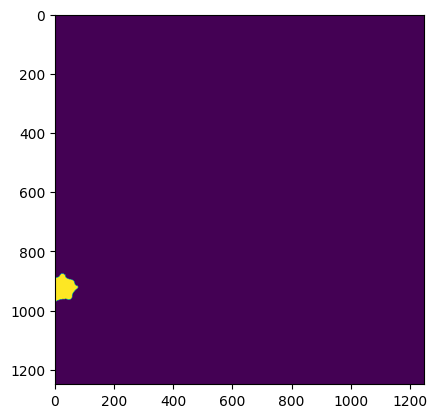

In [15]:
def f(x):
    created = multiprocessing.Process()
    current = multiprocessing.current_process()
    # print ('running:', current.name, current._identity)
    print (current._identity[0], " ")
    
    # print ('created:', created.name, created._identity)
    return x * x

p = multiprocessing.Pool(2)
print (p.map(f, range(6)))

158157    

158157    

157158    



[0, 1, 4, 9, 16, 25]


In [8]:

def init_pool(img, vol_threshold, min_fraction_to_split, num_procs):
  global p_img
  global p_vol_threshold
  global p_min_fraction_to_split
  global p_num_procs
  
  p_img = img
  p_vol_threshold = vol_threshold
  p_min_fraction_to_split = min_fraction_to_split
  p_num_procs = num_procs
  

def parallel_process_segment_wrapper(id):
  print("instance", id)
  print("process id", multiprocessing.current_process()._identity[0])

def parallel_cleanup_segmentation_image(img, vol_threshold, min_fraction_to_split, num_procs):
  clean_img = np.zeros(img.shape)
  # Eliminate any background pixels
  img = np.where(img==(2**64 - 1), 0, img)
  # Track current max label for creating new labels if needed
  max_label = np.max(img)
  (unique, counts) = np.unique(img, return_counts=True)
  
  pool = multiprocessing.Pool(2, initializer=init_pool, initargs=(img, vol_threshold, min_fraction_to_split, num_procs))
  
  task_list = list(zip(unique,counts))
  pool.map(parallel_process_segment_wrapper, task_list[:10])
  
  # for i in tqdm(range(len(unique))):
  #   # Ignore background segments. Can be splintered
  #   if (unique[i] == 0):
  #     continue
  #   # Process segment only if above threshold
  #   if (counts[i] >= vol_threshold):
  #     mask, max_label = process_segment(img, unique[i], counts[i], min_fraction_to_split, max_label)
  #     clean_img += mask
      
      
  
  return clean_img

In [9]:
clean_neuron_ids = parallel_cleanup_segmentation_image(neuron_ids, 100, 0.1, 1)